In [34]:
import numpy
import pandas
import nibabel as nib
import SimpleITK as sitk
from datetime import datetime
import cc3d
import os
import subprocess

In [26]:
import matplotlib.pyplot as plt

In [27]:
import torch

### steps are: 

- [x] load the preprocessed image.

- [x] run synth seg

- [ ] resample the image back to the size of the preprocessed image.

- [ ] check that it aligns properly

- [ ] delete any extra files created by synthseg

- [ ] extract just the ventricle components

- [ ] create the 10mm area around the ventricles using euclidian distance.

- [ ] save a file that contains just the ventricle and the DWMH / PVWMH area? (0 = background, 1 = deep, 2 = PV, 3 = ventricle

- [ ] turn this into a script that I can run on all the images

In [30]:
folder = "/home/s2208943/ipdis/data/preprocessed_data/MSS3_InterRaterData/imgs/"
file = "MSS3_ED_004_V1_T1.nii.gz"
path = folder + file

In [44]:
orig = nib.load(path)
odata = orig.get_fdata()

In [46]:
subprocess.run(['sh', 'vent_seg.sh', path, "/home/s2208943/test_synthseg_file"])

2024-02-29 12:18:28.846551: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-02-29 12:18:28.940714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:1c:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-02-29 12:18:28.963527: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2024-02-29 12:18:29.460125: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-02-29 12:18:29.744719: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2024-02-29 12:18:29.788908: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcu


SynthSeg 2.0

using 1 thread
predicting 1/1

segmentation  saved in:    /home/s2208943/test_synthseg_file/MSS3_ED_004_V1_T1_synthseg.nii.gz

If you use this tool in a publication, please cite:
SynthSeg: domain randomisation for segmentation of brain MRI scans of any contrast and resolution
B. Billot, D.N. Greve, O. Puonti, A. Thielscher, K. Van Leemput, B. Fischl, A.V. Dalca, J.E. Iglesias


Using TensorFlow backend.


CompletedProcess(args=['sh', 'vent_seg.sh', '/home/s2208943/ipdis/data/preprocessed_data/MSS3_InterRaterData/imgs/MSS3_ED_004_V1_T1.nii.gz', '/home/s2208943/test_synthseg_file'], returncode=0)

In [49]:
from twaidata.MRI_preprep.resample import resample_and_return, resample_and_save
import SimpleITK as sitk

In [52]:
synthseg_file = "/home/s2208943/test_synthseg_file/MSS3_ED_004_V1_T1_synthseg.nii.gz"
resampled = "/home/s2208943/test_synthseg_file/MSS3_ED_004_V1_T1_synthseg_resampled.nii.gz"

In [53]:
outspacing = sitk.ReadImage(path).GetSpacing() # get the spacing from the preprocessed image
print(outspacing)
resample_and_save(synthseg_file, resampled, is_label=True, out_spacing=outspacing, overwrite=True)

(1.0, 1.0, 3.0)
original spacing:  None
using original spacing derived from image


In [69]:
### load the resampled synthseg
data = nib.load(resampled).get_fdata()
data = torch.from_numpy(data)
data = data[0:odata.shape[0], 0:odata.shape[1], 0:odata.shape[2]]

In [70]:
data.shape, odata.shape

(torch.Size([240, 240, 53]), (240, 240, 53))

In [112]:
img = torch.ones([*data.shape, 4])
img[:,:,:,1] = (data != 4)
img[:,:,:,2] = (data != 43)
img[:,:,:,3] = (data == 4) | (data == 43) # alpha channel

In [132]:
import proplot as pplt

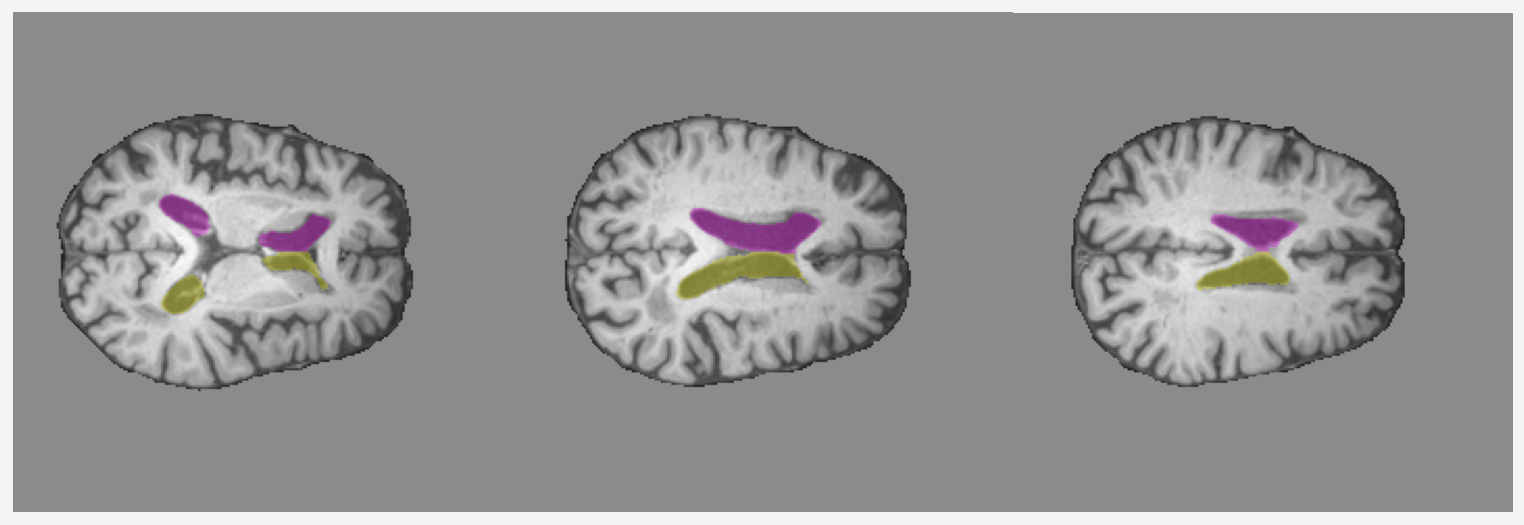

In [138]:
fig = pplt.figure(space=0, refwidth='20em')
axs = fig.subplots(nrows=1, ncols=3)

islice = 30
axs[0].imshow(odata[:,:,islice], cmap='gray', vmin=-3, vmax=2.5)
axs[0].imshow(img[:,:,islice], alpha=0.3)

islice = 33
axs[1].imshow(odata[:,:,islice], cmap='gray', vmin=-3, vmax=2.5)
axs[1].imshow(img[:,:,islice], alpha=0.3)

islice = 35
axs[2].imshow(odata[:,:,islice], cmap='gray', vmin=-3, vmax=2.5)
axs[2].imshow(img[:,:,islice], alpha=0.3)

for ax in axs:
    ax.axis('off')
    for spine in ax.spines:
        ax.spines[spine].set_color('none')
        
fig.save("synthseg ventricle segmentation example.png")

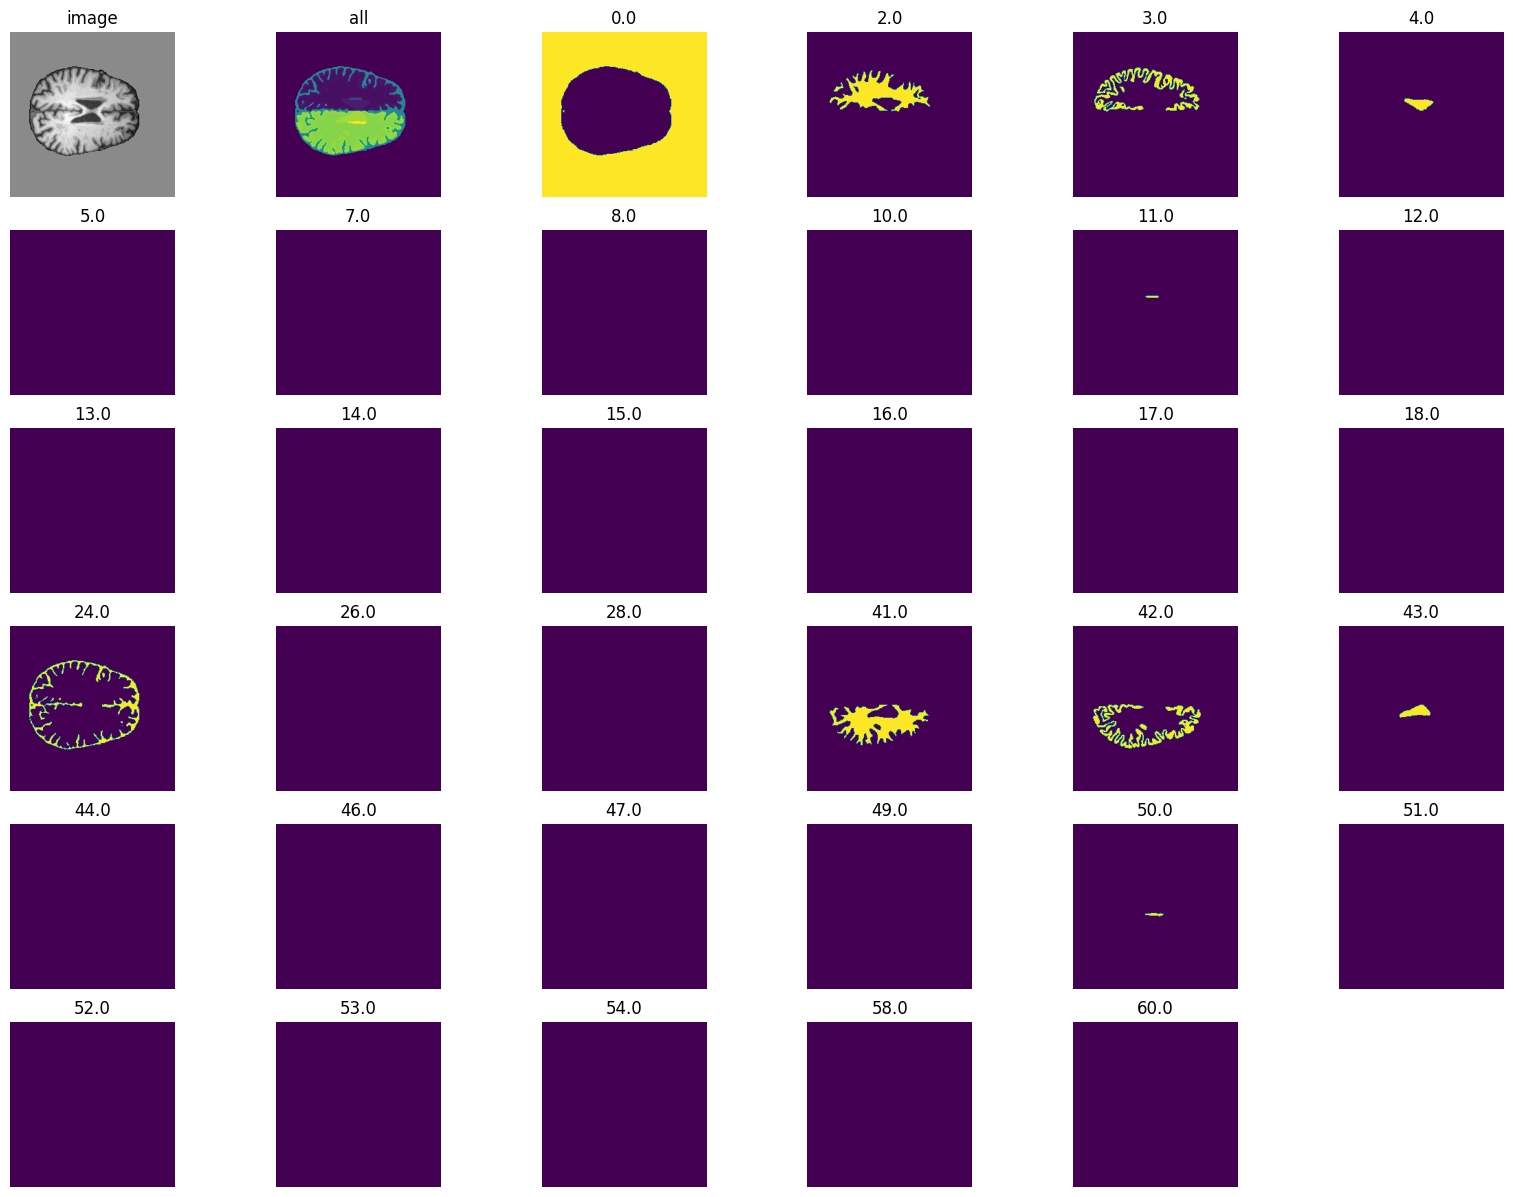

In [63]:
islice = 35
plt.figure(figsize=(20, 15))
plt.subplot(6, 6, 1)
plt.imshow(odata[:,:,islice], cmap='gray')
plt.axis('off')
plt.title("image")
plt.subplot(6, 6, 2)
plt.imshow(data[:,:,islice])
plt.axis('off')
plt.title("all")
for i, ccid in enumerate(data.unique()):
    plt.subplot(6,6,i+3)
    plt.imshow(data[:,:,islice]==ccid)
    plt.axis('off')
    plt.title(ccid.item())
